# import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import datetime
from sklearn.model_selection import train_test_split
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from collections import Counter
import re
from sklearn.preprocessing import StandardScaler

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

# Cleaning and Prepping Data

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Заполним пустые значения

Признак Cuisine Style

In [13]:
#Исследуем

data['Cuisine Style']

0                                           ['Bar', 'Pub']
1        ['European', 'Scandinavian', 'Gluten Free Opti...
2                                  ['Vegetarian Friendly']
3        ['Italian', 'Mediterranean', 'European', 'Vege...
4        ['Italian', 'Mediterranean', 'European', 'Seaf...
                               ...                        
49995    ['Italian', 'Vegetarian Friendly', 'Vegan Opti...
49996    ['French', 'American', 'Bar', 'European', 'Veg...
49997                                ['Japanese', 'Sushi']
49998    ['Polish', 'European', 'Eastern European', 'Ce...
49999                                          ['Spanish']
Name: Cuisine Style, Length: 50000, dtype: object

In [14]:
data['Cuisine Style'].value_counts()

['Italian']                                                                                                        1332
['French']                                                                                                         1019
['Spanish']                                                                                                         860
['French', 'European']                                                                                              503
['Cafe']                                                                                                            500
                                                                                                                   ... 
['European', 'Central European', 'American', 'Diner', 'Vegetarian Friendly']                                          1
['Indian', 'Asian', 'Nepali', 'Halal']                                                                                1
['Austrian', 'European', 'Central Europe

Сохраним нулевые значения, заполним пустые

In [15]:
data['NAN_Cuisine Style'] = pd.isna(data['Cuisine Style']).astype('float64')
data['Cuisine Style'].fillna("['Other']", inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        50000 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
NAN_Cuisine Style    50000 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 4.6+ MB


Признак Price Range

In [17]:
data['NAN_Price Range'] = pd.isna(data['Price Range']).astype('float64')

data['Price Range'] = data['Price Range'].fillna(0)


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        50000 non-null object
Ranking              50000 non-null float64
Price Range          50000 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
NAN_Cuisine Style    50000 non-null float64
NAN_Price Range      50000 non-null float64
dtypes: float64(5), int64(1), object(7)
memory usage: 5.0+ MB


Признак Number of Reviews

In [19]:
data['NAN_Number_of_Reviews_is'] = pd.isna(data['Number of Reviews']).astype('float64')

In [20]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
Restaurant_id               50000 non-null object
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null object
Number of Reviews           50000 non-null float64
Reviews                     49998 non-null object
URL_TA                      50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
dtypes: float64(6), int64(1), object(7)
memory usage: 5.3+ MB


In [22]:
data['NAN_Reviews'] = pd.isna(data['Reviews']).astype('float64')
data['Reviews'].fillna("[[], []]", inplace=True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
Restaurant_id               50000 non-null object
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null object
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
URL_TA                      50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
dtypes: float64(7), int64(1), object(7)
memory usage: 5.7+ MB


### 2. Обработка признаков

Restaurant_id

In [24]:
data.Restaurant_id.value_counts()

id_871      19
id_227      19
id_436      19
id_633      19
id_585      18
            ..
id_8479      1
id_15649     1
id_11399     1
id_15359     1
id_9065      1
Name: Restaurant_id, Length: 13094, dtype: int64

Возможно данный признак зависит от порядка добавления ресторана, а это может сказаться на рейтинге. Оставим, преобразовав

In [25]:
def change_id(x):
    if 'id_' in str(x):
        return str(x).replace('id_', '')
    else: return x
data.Restaurant_id = data.Restaurant_id.apply(change_id)
data.Restaurant_id = pd.to_numeric(data.Restaurant_id)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null object
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
URL_TA                      50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
dtypes: float64(7), int64(2), object(6)
memory usage: 5.7+ MB


Признак City

In [27]:
data.City.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [28]:
data['City_origin'] = data['City']

In [29]:
#data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null object
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
URL_TA                      50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
dtypes: float64(7), int64(2), object(7)
memory usage: 6.1+ MB


Cuisine Style

In [31]:
type(data['Cuisine Style'].iloc[0])

str

In [32]:
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: re.findall('\w+\s*\w+\s*\w+', str(x)))

In [33]:
type(data['Cuisine Style'].iloc[15])

list

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null object
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
URL_TA                      50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
dtypes: float64(7), int64(2), object(7)
memory usage: 6.1+ MB


Ranking

In [35]:
data.Ranking.value_counts()

93.0       22
72.0       21
491.0      21
842.0      21
1013.0     20
           ..
8027.0      1
10415.0     1
14621.0     1
11766.0     1
10585.0     1
Name: Ranking, Length: 12975, dtype: int64

Оставляем как есть

In [36]:
data['Price Range'].value_counts()

$$ - $$$    23041
0           17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [37]:
#Преобразуем

price_dict = {"0": 0, "$": 1, "$$ - $$$": 2, "$$$$": 3}

data['Price Range'] = data['Price Range'].replace(to_replace=price_dict)
data['Price Range'].value_counts()

2    23041
0    17361
1     7816
3     1782
Name: Price Range, dtype: int64

Number of Reviews

In [38]:
data['Number of Reviews'].value_counts()

0.0       3200
2.0       2403
3.0       2042
4.0       1707
5.0       1471
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: Number of Reviews, Length: 1574, dtype: int64

****Reviews

In [39]:
type(data.Reviews.iloc[0])

str

In [40]:
data['Reviews'].value_counts()

[[], []]                                                                                                                              8114
[['Happened to drop in', 'Right for a quick bite'], ['11/30/2016', '06/20/2015']]                                                        2
[['Very average food. Over average prices.', 'great food with great service!'], ['11/17/2017', '08/17/2017']]                            2
[['Whenever in Madrid, we never miss this gem...', 'Underrated sushi restaurant with very good...'], ['04/11/2017', '12/02/2016']]       2
[['Great food, service and atmosphere', 'Decor and food'], ['11/06/2017', '10/22/2017']]                                                 2
                                                                                                                                      ... 
[['Good food; good price.'], ['12/21/2012']]                                                                                             1
[['Nice traditional sushi s

In [41]:
def fill_na_reviews(x):
    if x == '[[], []]':
        return None
    else:
        return x
data['Reviews'] = data['Reviews'].fillna(fill_na_reviews)

In [42]:
data['Review_date'] = data['Reviews'].str.findall('\d+/\d+/\d+')


In [43]:
data['Review_date']

0                              []
1        [12/05/2017, 10/29/2017]
2        [12/28/2017, 12/06/2017]
3        [12/06/2017, 11/22/2017]
4        [02/08/2018, 01/24/2018]
                   ...           
49995    [12/16/2017, 11/12/2017]
49996    [12/21/2017, 12/12/2017]
49997    [11/03/2016, 04/12/2008]
49998    [07/11/2017, 06/18/2017]
49999    [01/31/2016, 07/04/2012]
Name: Review_date, Length: 50000, dtype: object

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
URL_TA                      50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
dtypes: float64(7), int64(3), object(

In [45]:
data.URL_TA

0        /Restaurant_Review-g187147-d10746918-Reviews-L...
1        /Restaurant_Review-g189934-d6674944-Reviews-Ra...
2        /Restaurant_Review-g186525-d13129638-Reviews-B...
3        /Restaurant_Review-g186338-d680417-Reviews-Qui...
4        /Restaurant_Review-g274924-d1112354-Reviews-Ma...
                               ...                        
49995    /Restaurant_Review-g187849-d2104414-Reviews-Ro...
49996    /Restaurant_Review-g187147-d1800036-Reviews-La...
49997    /Restaurant_Review-g189852-d947615-Reviews-Sus...
49998    /Restaurant_Review-g274856-d1100838-Reviews-Ho...
49999    /Restaurant_Review-g187849-d1109020-Reviews-Ta...
Name: URL_TA, Length: 50000, dtype: object

In [46]:
data.drop(['URL_TA'], axis=1, inplace=True)

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null object
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
dtypes: float64(7), int64(3), object(6)
memory usage: 6.1+ MB


In [48]:
data.ID_TA

0        d10746918
1         d6674944
2        d13129638
3          d680417
4         d1112354
           ...    
49995     d2104414
49996     d1800036
49997      d947615
49998     d1100838
49999     d1109020
Name: ID_TA, Length: 50000, dtype: object

Пока не знаем понадобится ли, преобразуем в числовой признак

In [49]:
def change_id_TA(x):
    if 'd' in str(x):
        return str(x).replace('d', '')
    else: return x
data.ID_TA = data.ID_TA.apply(change_id_TA)
data.ID_TA = pd.to_numeric(data.ID_TA)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
dtypes: float64(7), int64(4), object(5)
memory usage: 6.1+ MB


# Feature Engeneering

In [51]:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'ID_TA', 'sample', 'Rating',
       'NAN_Cuisine Style', 'NAN_Price Range', 'NAN_Number_of_Reviews_is',
       'NAN_Reviews', 'City_origin', 'Review_date'],
      dtype='object')

In [52]:
cuisines = set()

for i in data['Cuisine Style']:
    for j in i:
        cuisines.add(j)

In [53]:
cuisines

{'Afghani',
 'African',
 'Albanian',
 'American',
 'Arabic',
 'Argentinean',
 'Armenian',
 'Asian',
 'Australian',
 'Austrian',
 'Azerbaijani',
 'Balti',
 'Bangladeshi',
 'Bar',
 'Barbecue',
 'Belgian',
 'Brazilian',
 'Brew Pub',
 'British',
 'Burmese',
 'Cafe',
 'Cajun',
 'Cambodian',
 'Canadian',
 'Caribbean',
 'Caucasian',
 'Central American',
 'Central Asian',
 'Central European',
 'Chilean',
 'Chinese',
 'Colombian',
 'Contemporary',
 'Creole',
 'Croatian',
 'Cuban',
 'Czech',
 'Danish',
 'Delicatessen',
 'Diner',
 'Dutch',
 'Eastern European',
 'Ecuadorean',
 'Egyptian',
 'Ethiopian',
 'European',
 'Fast Food',
 'Filipino',
 'French',
 'Fujian',
 'Fusion',
 'Gastropub',
 'Georgian',
 'German',
 'Gluten Free Options',
 'Greek',
 'Grill',
 'Halal',
 'Hawaiian',
 'Healthy',
 'Hungarian',
 'Indian',
 'Indonesian',
 'International',
 'Irish',
 'Israeli',
 'Italian',
 'Jamaican',
 'Japanese',
 'Korean',
 'Kosher',
 'Latin',
 'Latvian',
 'Lebanese',
 'Malaysian',
 'Mediterranean',
 'Mex

In [54]:
food = {}  # создаём пустой словарь для хранения информации об ингредиентах
for item in cuisines:  # перебираем список ингредиентов
    food[item] = 0 # добавляем в словарь ключ, соответствующий очередному ингредиенту

for i in data['Cuisine Style']:   # перебираем список рецептов
    for j in i:   # и список ингредиентов в каждом рецепте
        food[j] += 1   # увеличиваем значение нужного ключа в словаре на 1

In [55]:
food

{'Hungarian': 444,
 'Indian': 1328,
 'Caribbean': 124,
 'Portuguese': 1385,
 'Cajun': 27,
 'Delicatessen': 473,
 'Salvadoran': 1,
 'Middle Eastern': 980,
 'Contemporary': 652,
 'Canadian': 7,
 'Dutch': 368,
 'Sushi': 1450,
 'Latvian': 1,
 'Taiwanese': 30,
 'Vegan Options': 5684,
 'Other': 11590,
 'Asian': 3786,
 'Albanian': 8,
 'Central Asian': 12,
 'Vegetarian Friendly': 14021,
 'Tibetan': 29,
 'European': 12561,
 'Cuban': 32,
 'Barbecue': 710,
 'Fast Food': 2122,
 'Mexican': 572,
 'Nepali': 121,
 'German': 820,
 'Kosher': 56,
 'Singaporean': 21,
 'Russian': 66,
 'South American': 490,
 'Jamaican': 36,
 'Peruvian': 130,
 'International': 1966,
 'Venezuelan': 51,
 'Croatian': 33,
 'Persian': 77,
 'Uzbek': 5,
 'Italian': 7433,
 'Indonesian': 71,
 'Xinjiang': 1,
 'Polynesian': 2,
 'New Zealand': 7,
 'Chilean': 16,
 'Central American': 168,
 'Sri Lankan': 30,
 'Armenian': 17,
 'Ecuadorean': 8,
 'Lebanese': 397,
 'Australian': 36,
 'Brazilian': 152,
 'Central European': 1727,
 'Chinese': 1

In [56]:
pop_cuisine = []
for key, value in food.items():
    if value > 3000:
        pop_cuisine.append(key)
pop_cuisine

['Vegan Options',
 'Other',
 'Asian',
 'Vegetarian Friendly',
 'European',
 'Italian',
 'Gluten Free Options',
 'Pizza',
 'Pub',
 'Mediterranean',
 'Spanish',
 'French',
 'Bar']

In [57]:
type(data['Cuisine Style'].iloc[0])

list

In [58]:
def popular_cuisine(x):
    for element in pop_cuisine:
        if element in x:
            return 1
        else:
            continue
data['Popular_cuisine'] = data['Cuisine Style'].apply(popular_cuisine)

In [59]:
data['Popular_cuisine'].value_counts(dropna = False)

1.0    43646
NaN     6354
Name: Popular_cuisine, dtype: int64

In [60]:
data['Popular_cuisine'].fillna(0, inplace = True)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
Popular_cuisine             50000 non-null float64
dtypes: float64(8), int64(4), object(

In [62]:
data['Count_cuisines'] = data['Cuisine Style'].apply(lambda x: len(x))

In [63]:
data['Count_cuisines'].value_counts(dropna=False)

1     20738
2      7797
3      6635
4      5948
5      4486
6      2611
7      1294
8       365
9        93
10       26
11        4
21        1
15        1
13        1
Name: Count_cuisines, dtype: int64

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
Popular_cuisine             50000 non-null float64
Count_cuisines              50000 non

****Reviews

In [65]:
data['Review_date'] = data['Reviews'].str.findall('\d+/\d+/\d+')
data['len_of_reviews'] = data['Review_date'].apply(lambda x: x if x == None else len(x))
data['len_of_reviews'].value_counts(dropna = False)

2    36202
0     8114
1     5680
3        4
Name: len_of_reviews, dtype: int64

In [66]:
data['len_of_reviews'].fillna(2, inplace = True)

In [67]:
def days_to_now(row):
    if row['Review_date'] == None:
        return None
    return datetime.datetime.now() - pd.to_datetime(row['Review_date']).max()

def days_between_reviews(row):
    if row['Review_date'] == None:
        return None
    return pd.to_datetime(row['Review_date']).max() - pd.to_datetime(row['Review_date']).min()

data['Days_to_now'] = data.apply(days_to_now, axis = 1).dt.days
data['Days_between_reviews'] = data[data['len_of_reviews']==2].apply(days_between_reviews, axis = 1).dt.days


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
Popular_cuisine             50000 non-null float64
Count_cuisines              50000 non

In [69]:
data['Days_between_reviews'].value_counts(dropna = False)

NaN       13798
1.0         829
0.0         631
2.0         629
3.0         606
          ...  
1924.0        1
1554.0        1
1335.0        1
1576.0        1
1543.0        1
Name: Days_between_reviews, Length: 1311, dtype: int64

In [70]:
data['Days_to_now'] = data['Days_to_now'].fillna(data['Days_to_now'].median())
data['Days_between_reviews'] = data['Days_between_reviews'].fillna(data['Days_between_reviews'].median())


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
Popular_cuisine             50000 non-null float64
Count_cuisines              50000 non

City Origin

In [72]:
data['City_origin'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City_origin, dtype: int64

In [73]:
Сity_population_dict = {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}
data['Сity_population'] = data.apply(lambda row: Сity_population_dict[row['City_origin']], axis = 1)

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
Popular_cuisine             50000 non-null float64
Count_cuisines              50000 non

In [75]:
data['Сount_of_rest'] = data['City_origin'].map(data.groupby('City_origin')['Ranking'].max().to_dict())

In [76]:
data['Сount_of_rest'].value_counts()

16444.0    7193
13986.0    6108
8809.0     3813
7796.0     3395
6372.0     2705
6275.0     2694
5948.0     2589
4188.0     1816
3717.0     1647
3444.0     1443
3254.0     1372
3006.0     1314
2737.0     1186
2763.0     1145
2666.0     1126
2464.0     1033
2440.0     1021
2154.0      925
1960.0      836
1964.0      819
1787.0      776
1766.0      745
1601.0      685
1484.0      642
1413.0      590
1244.0      554
1137.0      488
1141.0      475
889.0       380
621.0       263
468.0       222
Name: Сount_of_rest, dtype: int64

In [77]:
data['Rest_on_person'] = data['Сity_population']/data['Сount_of_rest']

In [78]:
data['Rest_on_person']

0        0.157729
1        0.563541
2        0.290487
3        0.541717
4        0.479190
           ...   
49995    0.217689
49996    0.157729
49997    0.390016
49998    0.818942
49999    0.217689
Name: Rest_on_person, Length: 50000, dtype: float64

In [79]:
data['Ranking_on_city'] = data['Ranking'] / data['Сount_of_rest']

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 25 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
Popular_cuisine             50000 non-null float64
Count_cuisines              50000 non

# EDA 

In [81]:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'ID_TA', 'sample', 'Rating',
       'NAN_Cuisine Style', 'NAN_Price Range', 'NAN_Number_of_Reviews_is',
       'NAN_Reviews', 'City_origin', 'Review_date', 'Popular_cuisine',
       'Count_cuisines', 'len_of_reviews', 'Days_to_now',
       'Days_between_reviews', 'Сity_population', 'Сount_of_rest',
       'Rest_on_person', 'Ranking_on_city'],
      dtype='object')

### Посмотрим распределение признака

In [113]:
correlation = data[data['sample'] == 1][['Ranking', 'Price Range','Number of Reviews', 'Rating','Popular_cuisine', 'Count_cuisines', 'len_of_reviews', 'Days_to_now', 'Days_between_reviews', 'Сity_population', 'Сount_of_rest']].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

KeyError: "['len_of_reviews'] not in index"

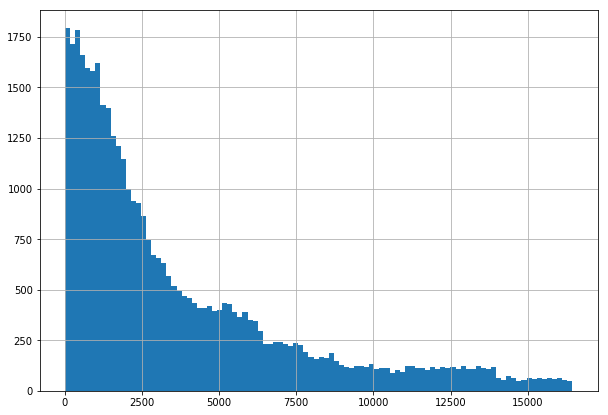

In [83]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

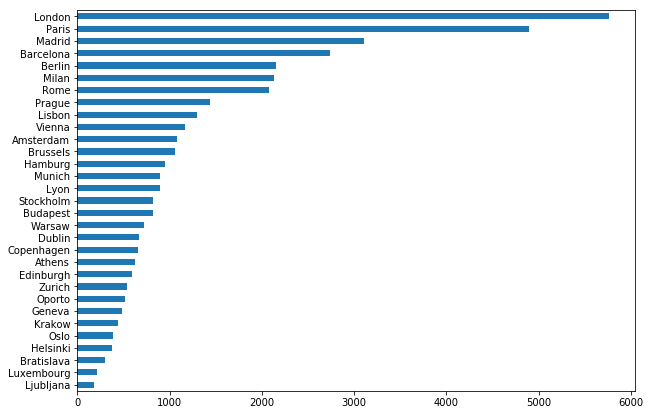

In [84]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

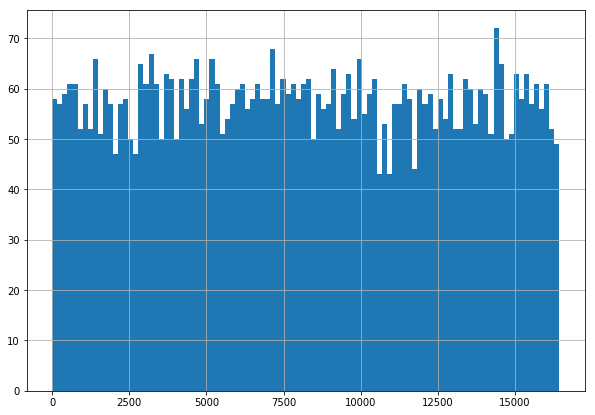

In [85]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

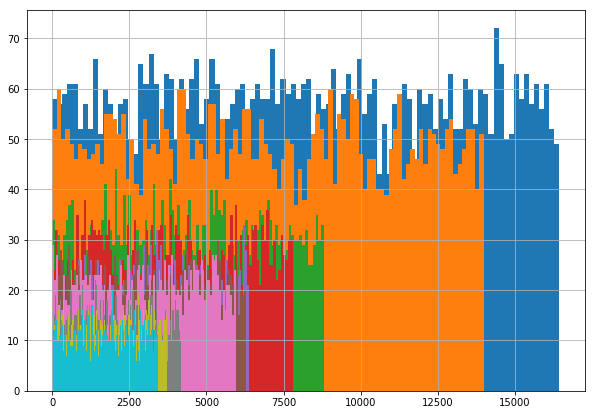

In [86]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

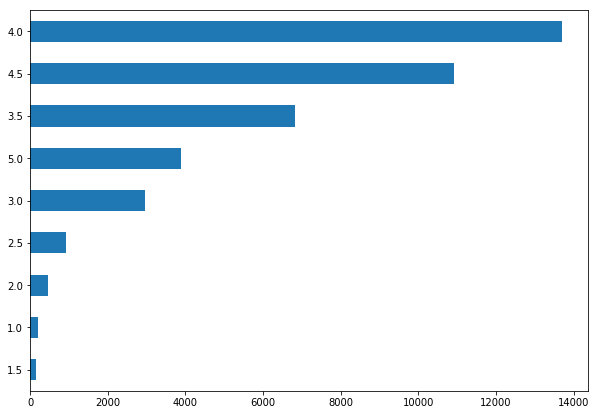

In [87]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

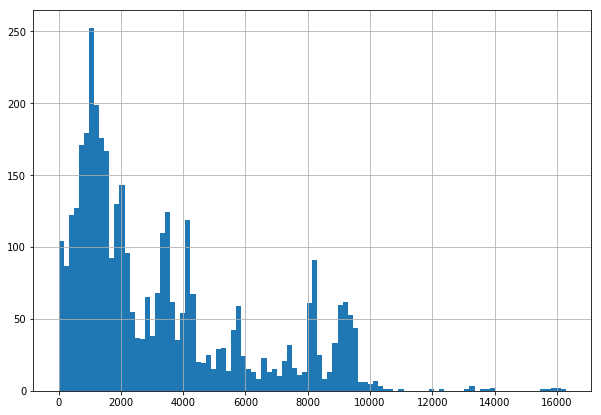

In [88]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

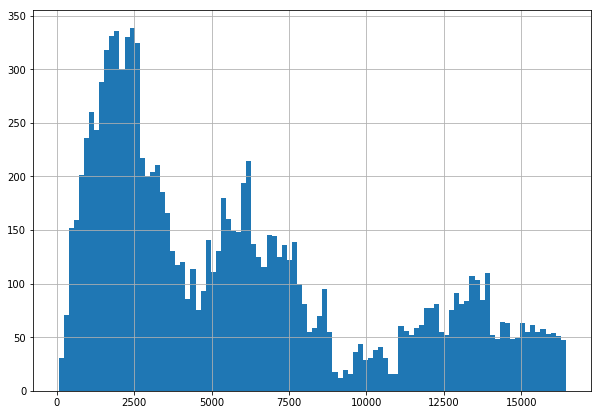

In [89]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

In [90]:
mn = data.groupby('City_origin')['Ranking'].mean()
st = data.groupby('City_origin')['Ranking'].std()
data['Std_Ranking'] = (data['Ranking'] - data['City_origin'].map(mn))/data['City_origin'].map(st)

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 26 columns):
Restaurant_id               50000 non-null int64
City                        50000 non-null object
Cuisine Style               50000 non-null object
Ranking                     50000 non-null float64
Price Range                 50000 non-null int64
Number of Reviews           50000 non-null float64
Reviews                     50000 non-null object
ID_TA                       50000 non-null int64
sample                      50000 non-null int64
Rating                      50000 non-null float64
NAN_Cuisine Style           50000 non-null float64
NAN_Price Range             50000 non-null float64
NAN_Number_of_Reviews_is    50000 non-null float64
NAN_Reviews                 50000 non-null float64
City_origin                 50000 non-null object
Review_date                 50000 non-null object
Popular_cuisine             50000 non-null float64
Count_cuisines              50000 non

# Data Preprocessing


In [92]:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'ID_TA', 'sample', 'Rating',
       'NAN_Cuisine Style', 'NAN_Price Range', 'NAN_Number_of_Reviews_is',
       'NAN_Reviews', 'City_origin', 'Review_date', 'Popular_cuisine',
       'Count_cuisines', 'len_of_reviews', 'Days_to_now',
       'Days_between_reviews', 'Сity_population', 'Сount_of_rest',
       'Rest_on_person', 'Ranking_on_city', 'Std_Ranking'],
      dtype='object')

In [93]:
data.drop(['Restaurant_id','NAN_Cuisine Style', 'NAN_Price Range', 'Cuisine Style', 'Reviews', 'ID_TA', 'NAN_Cuisine_Style', 'len_of_reviews','NAN_Price_Range', 'NAN_Number_of_Reviews_is','NAN_Reviews', 'City_origin', 'City', 'Review_date'], axis=1, inplace=True, errors='ignore')

In [94]:
data.columns

Index(['Ranking', 'Price Range', 'Number of Reviews', 'sample', 'Rating',
       'Popular_cuisine', 'Count_cuisines', 'Days_to_now',
       'Days_between_reviews', 'Сity_population', 'Сount_of_rest',
       'Rest_on_person', 'Ranking_on_city', 'Std_Ranking'],
      dtype='object')

In [95]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [96]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [97]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 13), (40000, 13), (40000, 12), (32000, 12), (8000, 12))

# Model 
Сам ML

In [98]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [99]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [100]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [101]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20386562499999997


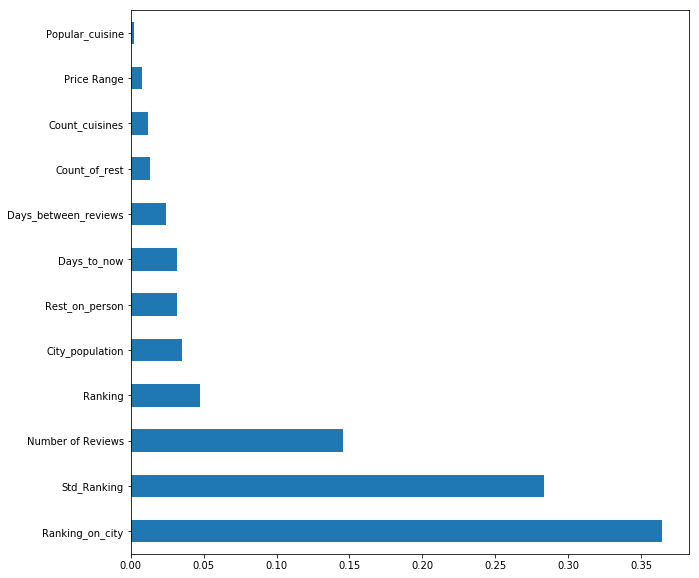

In [102]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [111]:
test_data.sample(5)

,Ranking,Price Range,Number of Reviews,Popular_cuisine,Count_cuisines,Days_to_now,Days_between_reviews,Сity_population,Сount_of_rest,Rest_on_person,Ranking_on_city,Std_Ranking
8965,12287.0,0,12.0,1.0,1,1826.0,67.0,2206,13986.0,0.157729,0.878521,1.323894
3530,2253.0,0,3.0,1.0,1,1073.0,67.0,1841,2737.0,0.672634,0.823164,1.106691
6680,576.0,0,24.0,1.0,1,1460.0,19.0,1841,2737.0,0.672634,0.210449,-1.008101
1778,3225.0,1,133.0,1.0,2,1134.0,648.0,2872,5948.0,0.482851,0.542199,0.148088
7330,45.0,1,290.0,1.0,6,924.0,5.0,506,3717.0,0.136131,0.012107,-1.702058


In [104]:
test_data = test_data.drop(['Rating'], axis=1)

In [105]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [106]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [107]:
predict_submission

array([3.04 , 4.21 , 4.24 , ..., 3.055, 4.475, 4.265])

In [109]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,3.040
1,id_1,4.210
2,id_2,4.240
3,id_3,4.330
4,id_4,4.475
